In [13]:
import os
import torch
from torch import nn
from torchvision import transforms, datasets

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # assuming you want to resize images to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

# Load data
train_data = datasets.ImageFolder(os.path.join('C:\\Users\\saikr\\Desktop\\Applied_ML', 'Training'), transform=transform)
test_data = datasets.ImageFolder(os.path.join('C:\\Users\\saikr\\Desktop\\Applied_ML', 'Testing'), transform=transform)

# Data loaders
batch_size = 64
num_classes = 4
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [14]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class TumorClassifierCNN(nn.Module):
    def __init__(self, block, num_blocks, num_classes):
        super(TumorClassifierCNN, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

# Instantiate the model with additional layers and a ResNet-like structure
model = TumorClassifierCNN(BasicBlock, [2, 2, 2, 2], num_classes=num_classes).to(device)


# Print the model
print(model)


TumorClassifierCNN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [15]:
def evaluate(model, data_loader, criterion):
    model.eval()  # set model to evaluation mode
    total_loss = 0
    total_correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            total_correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(data_loader)
    accuracy = total_correct / total
    return avg_loss, accuracy


In [16]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
num_epochs = 50


for epoch in range(num_epochs):
    model.train()  # set the model to training mode
    train_correct = 0
    train_total = 0
    train_loss = 0
    total_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        
        # Calculate accuracy
        train_correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
        train_total += labels.size(0)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_accuracy = train_correct / train_total
    train_loss = total_loss / len(train_loader)
    if epoch % 1 == 0:
        model.eval()  # set model to evaluation mode
        total_loss = 0
        total_correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                total_correct += (predicted == labels).sum().item()
        test_loss = total_loss / len(test_loader)
        accuracy = total_correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f},Train Accuracy: {train_accuracy * 100:.2f}%, Eval Accuracy: {accuracy * 100:.2f}%')

  




Epoch [1/50], Train Loss: 1.2192, Test Loss: 1.4269,Train Accuracy: 47.74%, Eval Accuracy: 35.03%
Epoch [2/50], Train Loss: 1.0857, Test Loss: 1.6569,Train Accuracy: 59.02%, Eval Accuracy: 39.34%
Epoch [3/50], Train Loss: 0.9818, Test Loss: 1.7686,Train Accuracy: 62.89%, Eval Accuracy: 35.79%
Epoch [4/50], Train Loss: 0.9122, Test Loss: 1.7401,Train Accuracy: 65.37%, Eval Accuracy: 39.85%
Epoch [5/50], Train Loss: 0.8477, Test Loss: 1.8765,Train Accuracy: 66.76%, Eval Accuracy: 33.76%
Epoch [6/50], Train Loss: 0.8105, Test Loss: 1.7618,Train Accuracy: 67.46%, Eval Accuracy: 37.06%
Epoch [7/50], Train Loss: 0.7701, Test Loss: 1.7733,Train Accuracy: 69.09%, Eval Accuracy: 35.79%
Epoch [8/50], Train Loss: 0.7219, Test Loss: 1.8033,Train Accuracy: 71.29%, Eval Accuracy: 40.86%
Epoch [9/50], Train Loss: 0.6895, Test Loss: 1.6637,Train Accuracy: 72.68%, Eval Accuracy: 47.21%
Epoch [10/50], Train Loss: 0.6600, Test Loss: 1.7308,Train Accuracy: 74.22%, Eval Accuracy: 40.86%
Epoch [11/50], Trai

In [18]:
model_path = 'new_tumor_classifier_model.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

Model saved to new_tumor_classifier_model.pth


Loaded best model.
Confusion Matrix:
[[ 19  34  34  13]
 [  0 114   1   0]
 [  0   0 105   0]
 [  0   3   6  65]]


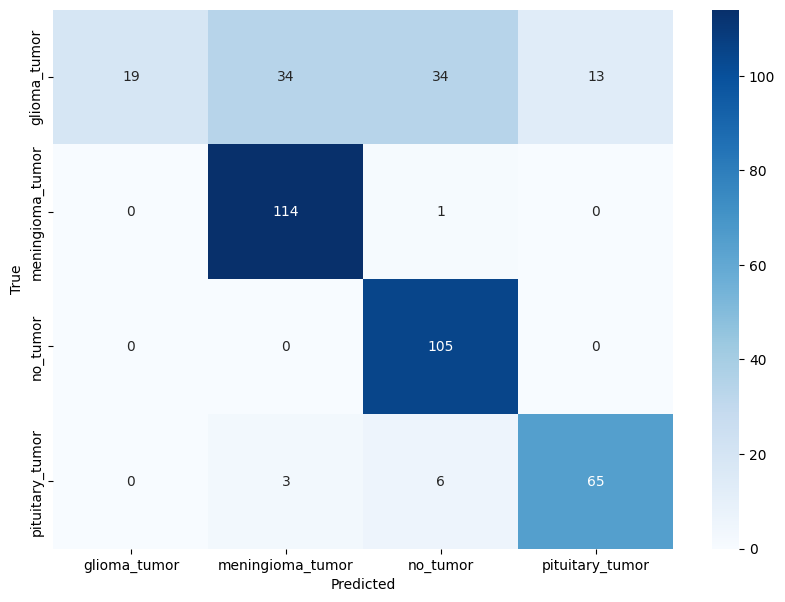

In [19]:


# Load the best model after training
model.load_state_dict(torch.load('new_tumor_classifier_model.pth'))
print("Loaded best model.")

model.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

conf_mat = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_mat)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=train_data.classes, yticklabels=train_data.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()